In [1]:
from PIL import Image
import torchvision
import torch
import numpy as np
import os
from studentnets import TinyNet
import transforms as T
import utils
import matplotlib.pyplot as plt
from torch import nn
import time
import datetime
import cv2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

teacher network

In [3]:
teacher_network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
teacher_network = teacher_network.to(device)

student network

In [4]:
network = TinyNet(device, 2).to(device)

load images

In [5]:
epochs = 2
b_size = 1

dataset

In [6]:
class teacherDataset(object):
    def __init__(self, video_name, transforms=None):
        self.transforms = transforms
        self.cap = cv2.VideoCapture(video_name)
        
    def __getitem__(self, idx):
        ret,img = self.cap.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = {}
        
        if self.transforms is not None:
            img, _ = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        frames_num = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        return  frames_num

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
def genMask(output, score_th = 0.9, mask_th = 0.2, CUDA = True):
    scores = output["scores"]
    masks = output["masks"]
    labels = output["labels"]
    mask_out = torch.sum(masks[(scores > score_th) & (labels == 1)], 0)
    
    mask_out = torch.squeeze(mask_out > mask_th)
        
    return mask_out

In [9]:
def criterion(input, target):
    loss = nn.functional.cross_entropy(input, target, ignore_index=255)
    return loss

In [10]:
video_name = "/media/yalu/6066C1DD66C1B3D6/Video/camera_{}.avi".format(0)
tDataset = teacherDataset(video_name, get_transform(train=False))

In [11]:
data_loader_teacher = torch.utils.data.DataLoader(
    tDataset, batch_size=b_size, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

In [12]:
optimizer = torch.optim.SGD(
    network.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda x: (1 - x / (len(data_loader_teacher) * 100)) ** 0.9)

In [13]:
teacher_network.eval()

cam_num = 4
epochs = 2

for epoch in range(epochs):
    for cam_id in range(cam_num):
        video_name = "/media/yalu/6066C1DD66C1B3D6/Video/camera_{}.avi".format(cam_id)
        tDataset = teacherDataset(video_name, get_transform(train=False))
        data_loader_teacher = torch.utils.data.DataLoader(
                tDataset, batch_size=b_size, shuffle=True, num_workers=4,
                collate_fn=utils.collate_fn)
        print("epoch:{},cam_id:{}".format(epoch,cam_id))
        step_loss = []
        start_time = time.time()
        for image, target in data_loader_teacher:
            image = image.to(device)

            # teacher network infer
            teacher_infer_start_time = time.time()
            outputs = teacher_network(list(image.unbind(0)))
            teacher_infer_time = time.time() - teacher_infer_start_time
            teacher_infer_time_str = str(datetime.timedelta(milliseconds=teacher_infer_time/b_size))
            # print('teacher infer time cost : {} '.format(teacher_infer_time_str))

            # generate teacher output as student target
            T_seg = [genMask(output) for output in outputs]
            T_seg = torch.stack(T_seg).long()

            # student network infer
            student_infer_start_time = time.time()
            student_out = network.forward(image)
            student_infer_time = time.time() - student_infer_start_time
            student_infer_time_str = str(datetime.timedelta(milliseconds=student_infer_time/b_size))
            # print('student infer time cost : {}'.format(student_infer_time_str))

            # train student network
            loss = criterion(student_out, T_seg)
            step_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
#             break
#         break
        print("step loss : ", np.mean(step_loss))
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('time cost : {}'.format(total_time_str))

epoch:0,cam_id:0
step loss :  0.05257805024695835
time cost : 0:05:11
epoch:0,cam_id:1
step loss :  0.03179420886113021
time cost : 0:05:27
epoch:0,cam_id:2
step loss :  0.050213679676606005
time cost : 0:04:01
epoch:0,cam_id:3
step loss :  0.023372226821802004
time cost : 0:03:49
epoch:1,cam_id:0
step loss :  0.045899299314576335
time cost : 0:05:23
epoch:1,cam_id:1
step loss :  0.05353737272709504
time cost : 0:05:32
epoch:1,cam_id:2
step loss :  0.06140720671832297
time cost : 0:04:03
epoch:1,cam_id:3
step loss :  0.03072609708241075
time cost : 0:03:45


In [22]:
video_name = "/media/yalu/6066C1DD66C1B3D6/Video/camera_{}.avi".format(0)
test_Dataset = teacherDataset(video_name, get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
        test_Dataset, batch_size=b_size, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

In [23]:
for image, target in data_loader_teacher:
    cnt += 10
    if(cnt == 100):
    image = image.to(device)
    break

In [24]:
teacher_infer_start_time = time.time()
teacher_out = teacher_network(list(image.unbind(0)))
teacher_infer_time = time.time() - teacher_infer_start_time
teacher_infer_time_str = str(datetime.timedelta(milliseconds=teacher_infer_time/b_size))
print('teacher infer time cost : {} '.format(teacher_infer_time_str))
# generate teacher output as student target
T_seg = [genMask(output) for output in teacher_out]
T_seg = torch.stack(T_seg).long()

teacher infer time cost : 0:00:00.000212 


In [25]:
student_infer_start_time = time.time()
student_out = network.forward(image)
student_infer_time = time.time() - student_infer_start_time
student_infer_time_str = str(datetime.timedelta(milliseconds=student_infer_time/b_size))
print('student infer time cost : {}'.format(student_infer_time_str))

student infer time cost : 0:00:00.000003


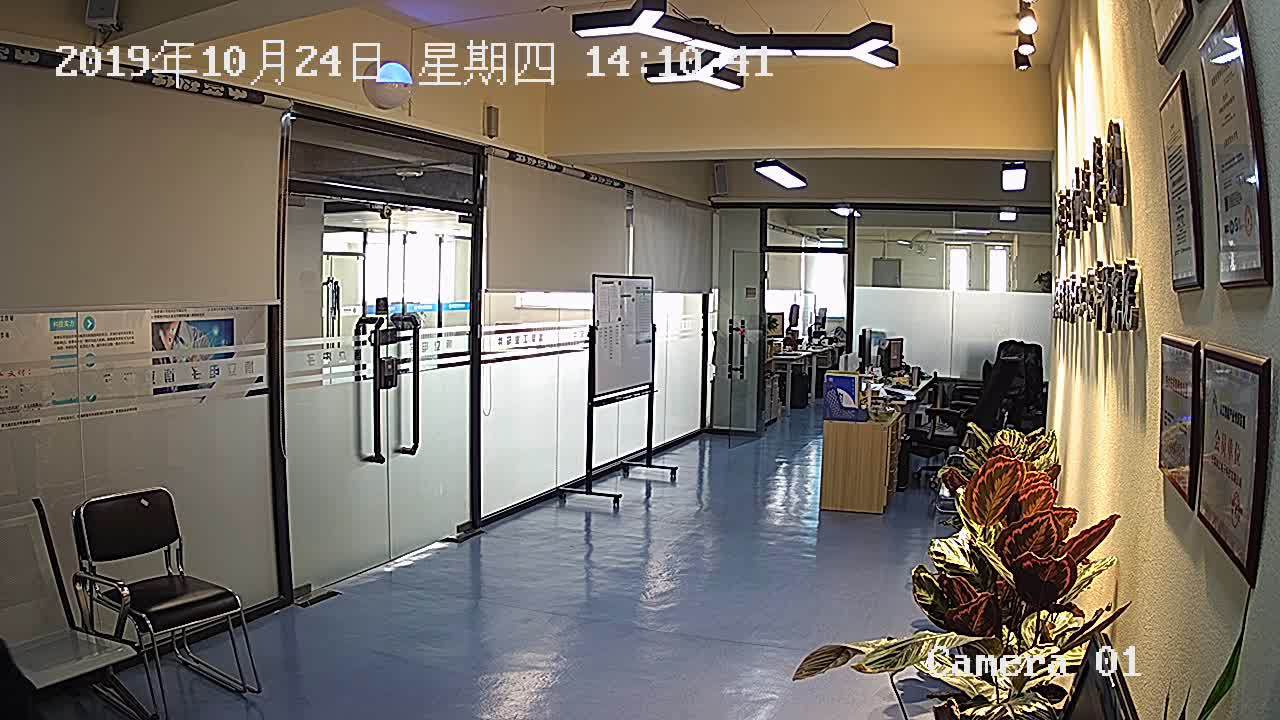

In [26]:
torchvision.transforms.ToPILImage()(image[0].cpu())

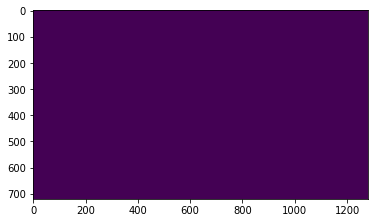

In [27]:
plt.imshow(T_seg[0].cpu().detach().numpy())

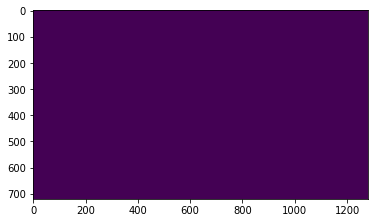

In [28]:
plt.imshow(student_out[0].cpu().detach().numpy()[0] < 0.1)

In [21]:
torch.save(network, "student.pkl")